In [1]:
from bayes_opt import BayesianOptimization
from numpy.random import seed
import libCERNBotPy as cbp
from numpy import genfromtxt
import numpy as np
from time import sleep
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
%matplotlib inline
from scipy import signal
from bayes_opt.observer import JSONLogger, ScreenLogger
from bayes_opt.event import Events
from sklearn.gaussian_process.kernels import Matern, RBF

In [2]:
#Init robot
wr = cbp.Wrapper("can0", "vmuLog.csv")
wr.init()
wr.setVelocity(0., -0.025)
poslimit = [0,-5]

In [6]:
#For safety reasons (dist is positive)
direction = 1
def decideVelocityDirection(dist):
    global direction
    x = wr.getXposition()
    direction *= -1
    return direction
wr.setVelocity(0., -0.7)

Taccel = 0.25
def moveRobot(A2, dT):
    v_desired = (1.5 + A2) * Taccel 
    A = v_desired / Taccel
    sign = decideVelocityDirection(v_desired*3)
    A1 = 1.5
    wr.setVelocity(sign * A1 * Taccel, A1)
    sleep(dT/1000.0)
    A2 = A2
    wr.setVelocity(sign * v_desired, A2)
    sleep(3)
    wr.setVelocity(0., 0.5)
    
def func(a1, t1):
    losscum = 0
    for _ in range(2):
        wr.startVMULogger()
        sleep(0.1)
        moveRobot(a1, t1)
        wr.stopVMULogger()
        vmu = genfromtxt("vmuLog.csv", delimiter=";")

        ##Filter
        w = 0.05
        b, a = signal.butter(5, w, 'low')
        output = signal.filtfilt(b, a, vmu[:,1])
        loss = np.sum(np.sqrt(np.power(output, 2))/ vmu.shape[0]) 
        losscum += loss
        #loss = np.sum(np.sqrt(np.power(vmu[:, 1], 2)))/ vmu.shape[0] #RMSE
        fig, ax = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis
        ax.plot(vmu[:,1])
        fig.savefig('figures/K{:.2f}_T2{:.2f}_loss{:.2f}.png'.format(a1, t1,loss))
        plt.close()
        sleep(5)
    return -losscum/2

In [13]:
logger = JSONLogger(path="logs.json")
optimizer = BayesianOptimization(
    func,
    {'a1': (0, 1.5),
    't1': (300, 1000)})
optimizer.subscribe(Events.OPTMIZATION_STEP, logger)
optimizer.subscribe(Events.OPTMIZATION_STEP, ScreenLogger(verbose=2))
optimizer.set_gp_params(kernel=Matern(length_scale=[0.1, 10]))

In [14]:
optimizer.maximize( init_points=5,
    n_iter=30, acq="ucb", kappa=5.0)

|  1        | -10.29    |  0.7195   |  371.3    |
|  2        | -6.868    |  1.225    |  685.1    |
|  3        | -10.46    |  1.066    |  442.8    |
|  4        | -5.333    |  0.472    |  902.0    |
|  5        | -7.301    |  0.06732  |  567.9    |
|  6        | -7.205    |  0.0      |  786.7    |
|  7        | -6.219    |  0.212    |  1e+03    |
|  8        | -6.916    |  1.5      |  944.7    |
|  9        | -5.008    |  1.049    |  825.6    |
|  10       | -5.667    |  0.8469   |  1e+03    |
|  11       | -4.857    |  0.6748   |  778.3    |
|  12       | -4.659    |  0.7981   |  873.8    |
|  13       | -7.729    |  0.0      |  300.0    |
|  14       | -4.504    |  0.8373   |  810.3    |
|  15       | -4.799    |  0.6396   |  836.0    |
|  16       | -4.913    |  0.8844   |  748.4    |
|  17       | -5.218    |  1.004    |  908.7    |
|  18       | -5.112    |  0.6878   |  926.8    |
|  19       | -4.719    |  0.8911   |  842.9    |
|  20       | -5.559    |  0.5831   |  691.2    |


In [15]:
loss1 = []
loss2 = []
loss3 = []
for i in range(10):
    print("Trial {}".format(i+1))
    loss1.append(-func(optimizer.max["params"]["a1"], optimizer.max["params"]["t1"]))
    loss2.append(-func(0.6, 927))
    loss3.append(-func(0., 1000))

Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9


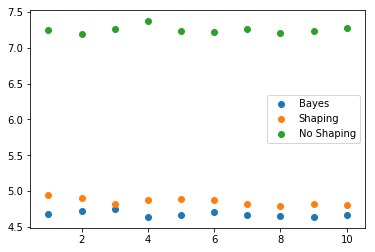

In [16]:
x = np.linspace(1, len(loss1), len(loss1))
p1 = plt.scatter(x, loss1)
p2 = plt.scatter(x, loss2)
p2 = plt.scatter(x, loss3)
plt.legend(("Bayes","Shaping", "No Shaping"))
plt.show()

In [22]:
moveRobot(0.6, 927)

In [18]:
wr.setVelocity(0.6, 1.8)
sleep(250/1000.0)
sleep(4)#2.5)
wr.setVelocity(0., 0.5)

True

In [30]:
loss3

[8.629270389676408,
 8.648136618547014,
 8.604288699350581,
 8.591022041955343,
 8.57477726953817,
 8.500803270985653,
 8.448755196538585,
 8.427190537316545,
 8.41872193697526,
 8.48985616419684]

In [4]:
wr.startVMULogger()

True

In [5]:
wr.stopVMULogger()

True

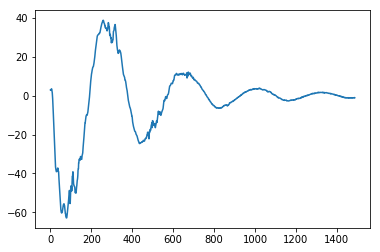

In [8]:
vmu = genfromtxt("vmuLog.csv", delimiter=";")
plt.plot(vmu[660:,1])
plt.show()

The K factor is : 0.5910289064817592
The second impulse is at : 937.0021246738952 msec


/home/robotronics/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


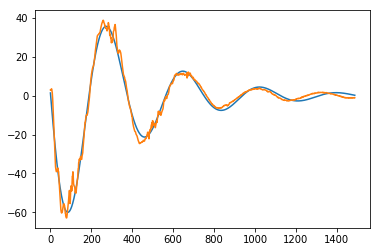

In [9]:
def dampedVibration(x, A, omega, damping, x0):
    coeff = np.sqrt(1 - damping*damping)
    y = (A * omega) / coeff * np.exp(-damping * omega * (x - x0)) * np.sin(omega * coeff* (x - x0))
    return y
#Damped oscillation
from scipy.optimize import curve_fit
ydata = vmu[660:,1]
xdata = np.linspace(0, ydata.shape[0]-1, ydata.shape[0])
p0 = [300, 0.05, 0, 0]
popt, pcov = curve_fit(dampedVibration, xdata, ydata, p0)
plt.plot(xdata, dampedVibration(xdata, popt[0], popt[1], popt[2], popt[3]))
plt.plot(xdata,ydata)
damping = popt[2]
K = np.exp((-damping * np.pi) / (1- damping* damping))
print("The K factor is : {}".format(K))
omega = popt[1]
# This is in VMU measurement units, which is 5 millisec
t_i = np.pi / (omega * np.sqrt(1-damping* damping))
print("The second impulse is at : {} msec".format(t_i * 5))
#

In [19]:
vmu = genfromtxt("vmuLog.csv", delimiter=";")

##Filter
w = 0.05
b, a = signal.butter(5, w, 'low')
output = signal.filtfilt(b, a, vmu[:,1])
loss = np.sum(np.sqrt(np.power(output, 2)))/ vmu.shape[0] 
print(loss)

4.7847090419304195


In [53]:
wr.setVelocity(0., 0.2)

True